In [1]:
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from bluepysnap import Circuit
from bluepysnap.bbp import Cell

# CircuitPath = 'O1_data_physiology/' # edges files not inclued in https://github.com/FernandoSBorges/

CircuitPath = 'O1_data_physiology/'
MorphologyPath = CircuitPath + 'morphologies/ascii/'
CellLibraryFile = CircuitPath + 'S1nonbarrel_neurons/nodes.h5'
METypePath = CircuitPath + 'emodels_hoc/'

lst_properties = [ 'etype', 'exc_mini_frequency', 'inh_mini_frequency', 'layer', 'me_combo', 'model_template', 'model_type', 'morph_class', 'morphology', 'mtype', 
                  'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z', 'population', 'region', 'synapse_class', '@dynamics:holding_current', 
                  '@dynamics:input_resistance', '@dynamics:resting_potential', '@dynamics:threshold_current', 'x', 'y', 'z']

circuit_path = CircuitPath + 'circuit_config.json'
circuit = Circuit(circuit_path)

cells = circuit.nodes["S1nonbarrel_neurons"]

nodesinfo = cells.get()

def distance3D(gidpre,gidpost):
    return np.sqrt(np.power(nodesinfo['x'][gidpre]-nodesinfo['x'][gidpost],2)+np.power(nodesinfo['y'][gidpre]-nodesinfo['y'][gidpost],2)+np.power(nodesinfo['z'][gidpre]-nodesinfo['z'][gidpost],2))

def distance2D(gidpre,gidpost):
    return np.sqrt(np.power(nodesinfo['x'][gidpre]-nodesinfo['x'][gidpost],2)+np.power(nodesinfo['y'][gidpre]-nodesinfo['y'][gidpost],2))

def distance2Dmean(gidpre, mean_x, mean_y):
    return np.sqrt(np.power(nodesinfo['x_new'][gidpre]-mean_x,2)+np.power(nodesinfo['y_new'][gidpre]-mean_y,2))


mtypes = sorted(cells.property_values(Cell.MTYPE))

i = 0
mntypes = {}
for mn in sorted(mtypes):
    mntypes[mn] = i
    i+=1

print(mntypes)

{'L1_DAC': 0, 'L1_HAC': 1, 'L1_LAC': 2, 'L1_NGC-DA': 3, 'L1_NGC-SA': 4, 'L1_SAC': 5, 'L23_BP': 6, 'L23_BTC': 7, 'L23_CHC': 8, 'L23_DBC': 9, 'L23_LBC': 10, 'L23_MC': 11, 'L23_NBC': 12, 'L23_NGC': 13, 'L23_SBC': 14, 'L2_IPC': 15, 'L2_TPC:A': 16, 'L2_TPC:B': 17, 'L3_TPC:A': 18, 'L3_TPC:C': 19, 'L4_BP': 20, 'L4_BTC': 21, 'L4_CHC': 22, 'L4_DBC': 23, 'L4_LBC': 24, 'L4_MC': 25, 'L4_NBC': 26, 'L4_NGC': 27, 'L4_SBC': 28, 'L4_SSC': 29, 'L4_TPC': 30, 'L4_UPC': 31, 'L5_BP': 32, 'L5_BTC': 33, 'L5_CHC': 34, 'L5_DBC': 35, 'L5_LBC': 36, 'L5_MC': 37, 'L5_NBC': 38, 'L5_NGC': 39, 'L5_SBC': 40, 'L5_TPC:A': 41, 'L5_TPC:B': 42, 'L5_TPC:C': 43, 'L5_UPC': 44, 'L6_BP': 45, 'L6_BPC': 46, 'L6_BTC': 47, 'L6_CHC': 48, 'L6_DBC': 49, 'L6_HPC': 50, 'L6_IPC': 51, 'L6_LBC': 52, 'L6_MC': 53, 'L6_NBC': 54, 'L6_NGC': 55, 'L6_SBC': 56, 'L6_TPC:A': 57, 'L6_TPC:C': 58, 'L6_UPC': 59}


## Select nodes to simulate

In [2]:
f = open('node_sets.json') 
node_sets = json.load(f) 

mean_x, mean_y = np.mean(nodesinfo['x_new']), np.mean(nodesinfo['y_new'])
node_gid = [] 
nodepremtype_new = []    
mtype_new = []     


node_gid = []
hoclist = []
Morpholist = []
node_threshold_current = []
node_holding_current = []
hex = 'hex0'

for gid in [108767, 141766, 138433]:
    if 'L4_' in nodesinfo['mtype'][gid] and 'INH' in nodesinfo['synapse_class'][gid]:  
        nodepremtype_new.append(mntypes[nodesinfo['mtype'][gid]])
        if nodesinfo['mtype'][gid] not in mtype_new:
            mtype_new.append(nodesinfo['mtype'][gid])

        print(len(node_gid),gid,nodesinfo['synapse_class'][gid],nodesinfo['mtype'][gid],nodesinfo['model_template'][gid],nodesinfo['morphology'][gid],hex,distance2Dmean(gid, mean_x, mean_y))
        current1 = cells.get(gid,['@dynamics:threshold_current']).values[0]
        holding_current1 = cells.get(gid,['@dynamics:holding_current']).values[0]
        # print("%d %.5f %.5f" % (gid,current1,holding_current1))
        node_gid.append(gid)
        hoclist.append(nodesinfo['model_template'][gid][4:])
        Morpholist.append(nodesinfo['morphology'][gid])
        node_threshold_current.append(current1)
        node_holding_current.append(holding_current1)


for gid in [139867, 141213, 141369, 133426, 135956, 137858, 114264, 114284, 115007]:
# for gid in node_sets['hex0']['node_id']: 
    if 'L4_' in nodesinfo['mtype'][gid] and distance2Dmean(gid, mean_x, mean_y) > 0.0 and distance2Dmean(gid, mean_x, mean_y) < 250.0 and 'EXC' in nodesinfo['synapse_class'][gid]:  
        nodepremtype_new.append(mntypes[nodesinfo['mtype'][gid]])
        if nodesinfo['mtype'][gid] not in mtype_new:
            mtype_new.append(nodesinfo['mtype'][gid])

        print(len(node_gid),gid,nodesinfo['synapse_class'][gid],nodesinfo['mtype'][gid],nodesinfo['model_template'][gid],nodesinfo['morphology'][gid],hex,distance2Dmean(gid, mean_x, mean_y))
        current1 = cells.get(gid,['@dynamics:threshold_current']).values[0]
        holding_current1 = cells.get(gid,['@dynamics:holding_current']).values[0]
        # print("%d %.5f %.5f" % (gid,current1,holding_current1))
        node_gid.append(gid)
        hoclist.append(nodesinfo['model_template'][gid][4:])
        Morpholist.append(nodesinfo['morphology'][gid])
        node_threshold_current.append(current1)
        node_holding_current.append(holding_current1)


0 108767 INH L4_BP hoc:cNAC_L6NGC rp140319_ChC_3_idA_-_Scale_x1.000_y0.950_z1.000_-_Clone_1 hex0 234.2564792528448
1 141766 INH L4_BTC hoc:cNAC_L6NGC rp110127_L5-2_idG_-_Scale_x1.000_y0.950_z1.000 hex0 228.55813436360708
2 138433 INH L4_NBC hoc:cNAC_L6NGC rp110131_L5-1_idA_-_Scale_x1.000_y1.025_z1.000_-_Clone_0 hex0 240.58463264623518
3 139867 EXC L4_SSC hoc:cADpyr_L4UPC dend-rp120608_P_3_idD_axon-C120398A-P3_-_Clone_0 hex0 31.393362648875602
4 141213 EXC L4_SSC hoc:cADpyr_L4TPC dend-C120398A-P3_axon-sm100429a1-5_INT_idE_-_Scale_x1.000_y1.050_z1.000 hex0 14.133289344568627
5 141369 EXC L4_SSC hoc:cADpyr_L4TPC dend-rp120608_P_3_idD_axon-sm100429a1-5_INT_idG_-_Scale_x1.000_y1.050_z1.000_-_Clone_0 hex0 13.392510390054921
6 133426 EXC L4_TPC hoc:cADpyr_L4TPC dend-mtC050800E_idD_axon-sm100429a1-5_INT_idD_-_Scale_x1.000_y0.975_z1.000_-_Clone_0 hex0 2.8649318527718695
7 135956 EXC L4_TPC hoc:cADpyr_L4TPC dend-C231296A-P4B2_axon-mtC171001A_idA_-_Scale_x1.000_y0.950_z1.000 hex0 1.31280236169468

# NetPyNE

In [3]:
from netpyne import specs, sim   

# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

In [4]:
cellName_list = {}
cellName_list2 = []
gid_list = {}

Epops = []
Ipops = []

cellName_list2 = []

for gid in node_gid:

    cellName = nodesinfo['mtype'][gid] + '_' + nodesinfo['etype'][gid]
        
    cellName_list2.append(cellName)
    
    cellName_list[gid] = cellName + '_' + str(len(cellName_list2)-1)
    gid_list[cellName + '_' + str(len(cellName_list2)-1)] = gid
    
    print('%s %s %s 1 1 %d' % (cellName + '_' + str(len(cellName_list2)-1),nodesinfo['mtype'][gid],nodesinfo['etype'][gid],gid))

    if 'cADpyr' in cellName:
        Epops.append(cellName + '_' + str(len(cellName_list2)-1))
    else:
        Ipops.append(cellName + '_' + str(len(cellName_list2)-1))

L4_BP_cNAC_0 L4_BP cNAC 1 1 108767
L4_BTC_cNAC_1 L4_BTC cNAC 1 1 141766
L4_NBC_cNAC_2 L4_NBC cNAC 1 1 138433
L4_SSC_cADpyr_3 L4_SSC cADpyr 1 1 139867
L4_SSC_cADpyr_4 L4_SSC cADpyr 1 1 141213
L4_SSC_cADpyr_5 L4_SSC cADpyr 1 1 141369
L4_TPC_cADpyr_6 L4_TPC cADpyr 1 1 133426
L4_TPC_cADpyr_7 L4_TPC cADpyr 1 1 135956
L4_TPC_cADpyr_8 L4_TPC cADpyr 1 1 137858
L4_UPC_cADpyr_9 L4_UPC cADpyr 1 1 114264
L4_UPC_cADpyr_10 L4_UPC cADpyr 1 1 114284
L4_UPC_cADpyr_11 L4_UPC cADpyr 1 1 115007


In [5]:
cellsList = {}

for cellName in gid_list.keys():
    # try:    
        gid = gid_list[cellName]

        MorphoName = nodesinfo['morphology'][gid] + '.asc'

        hocName = nodesinfo['model_template'][gid][4:]  

        MorphologyPath = 'O1_data_physiology/morphologies/ascii'
        
        # MorphoName = nodesinfo['morphology'][gid]+"_gid"+str(gid)+".asc"

        print(cellName,hocName)
            
        cellRule = netParams.importCellParams(label=cellName, somaAtOrigin=True,
            conds={'cellType': cellName, 'cellModel': 'HH_full'},
            fileName='O1_data_physiology/emodels_hoc/' + hocName + '.hoc',
            cellName=hocName,
            cellInstance = False,
            cellArgs=[gid, MorphologyPath, MorphoName])
        
        # netParams.saveCellParamsRule(label=cellName, fileName=cellName+'_BBP_cellParams.json')

        cellsList[cellName] = [{'x': nodesinfo['x'][gid], 'y': nodesinfo['y'][gid], 'z': nodesinfo['z'][gid]}]
        # cellsList[cellName] = [{'x': nodesinfo['x'][gid] - 3000.0, 'y': nodesinfo['y'][gid] + 2000.0, 'z': nodesinfo['z'][gid] + 3500.0}]

        cellMe = cellName
        
        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma_0']['geom']['pt3d'][-1]

        netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam'] = 1.0
        # netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L'] = 30.0

        axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                                    (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                                    (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]



        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon_0_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]

        # netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam'] = 0.5
        # netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L'] = 30.0

        axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                                    (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                                    (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 


                    
        myelin_pt3d_x, myelin_pt3d_y, myelin_pt3d_z, axon_1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'][-1]

        # netParams.cellParams[cellMe]['secs']['myelin_0']['geom']['diam'] = 0.5
        netParams.cellParams[cellMe]['secs']['myelin_0']['geom']['L'] = 100.0

        myelin_pt3d_diam =  netParams.cellParams[cellMe]['secs']['myelin_0']['geom']['diam']
        myelin_pt3d_L =  netParams.cellParams[cellMe]['secs']['myelin_0']['geom']['L']

        netParams.cellParams[cellMe]['secs']['myelin_0']['geom']['pt3d'] = [(myelin_pt3d_x, myelin_pt3d_y, myelin_pt3d_z, myelin_pt3d_diam),
                                                                                    (myelin_pt3d_x, myelin_pt3d_y+myelin_pt3d_L/2.0, myelin_pt3d_z, myelin_pt3d_diam),
                                                                                    (myelin_pt3d_x, myelin_pt3d_y+myelin_pt3d_L, myelin_pt3d_z, myelin_pt3d_diam)] 

    # except:
    #     pass        

# cellsList

L4_BP_cNAC_0 cNAC_L6NGC
L4_BTC_cNAC_1 cNAC_L6NGC
L4_NBC_cNAC_2 cNAC_L6NGC
L4_SSC_cADpyr_3 cADpyr_L4UPC
L4_SSC_cADpyr_4 cADpyr_L4TPC
L4_SSC_cADpyr_5 cADpyr_L4TPC
L4_TPC_cADpyr_6 cADpyr_L4TPC
L4_TPC_cADpyr_7 cADpyr_L4TPC
L4_TPC_cADpyr_8 cADpyr_L4TPC
L4_UPC_cADpyr_9 cADpyr_L4TPC
L4_UPC_cADpyr_10 cADpyr_L4UPC
L4_UPC_cADpyr_11 cADpyr_L4UPC


In [6]:
layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#Th pop
ymin={'ss_RTN_o': 1000+1688, 'ss_RTN_m': 1000+1766, 'ss_RTN_i': 1000+1844, 'VPL_sTC': 1000+2000, 'VPM_sTC': 1000+2156, 'POm_sTC_s1': 1000+2312}
ymax={'ss_RTN_o': 1000+1766, 'ss_RTN_m': 1000+1844, 'ss_RTN_i': 1000+2000, 'VPL_sTC': 1000+2156, 'VPM_sTC': 1000+2312, 'POm_sTC_s1': 1000+2624}

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 30.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 1500.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 30.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
netParams.defaultThreshold = -20.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)
    
#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------
# netParams.cellParams[cellName]
for cellName in netParams.cellParams.keys():    
    netParams.popParams[cellName] = {'cellType': cellName, 'cellsList': cellsList[cellName], 'cellModel': 'HH_full'}

In [7]:
netParams.popParams.keys()

odict_keys(['L4_BP_cNAC_0', 'L4_BTC_cNAC_1', 'L4_NBC_cNAC_2', 'L4_SSC_cADpyr_3', 'L4_SSC_cADpyr_4', 'L4_SSC_cADpyr_5', 'L4_TPC_cADpyr_6', 'L4_TPC_cADpyr_7', 'L4_TPC_cADpyr_8', 'L4_UPC_cADpyr_9', 'L4_UPC_cADpyr_10', 'L4_UPC_cADpyr_11'])

In [8]:
netParams.synMechParams['E->E'] = {'mod': 'ProbAMPANMDA_EMS','Dep': 700.568,'Fac': 17.989,'Use': 0.327,'tau_d_AMPA': 1.738,'NMDA_ratio':0.8}                 

netParams.synMechParams['E->I'] = {'mod': 'ProbAMPANMDA_EMS','Dep': 700.568,'Fac': 17.989,'Use': 0.327,'tau_d_AMPA': 1.738,'NMDA_ratio':0.8}            
      
netParams.synMechParams['I->I'] = {'mod': 'ProbGABAAB_EMS','Dep': 775.316,'Fac': 9.435,'Use': 0.109,'tau_d_GABAA': 7.487,'GABAB_ratio':0.0}

netParams.synMechParams['I->E'] = {'mod': 'ProbGABAAB_EMS','Dep': 606.433,'Fac': 24.743,'Use': 0.0913,'tau_d_GABAA': 7.192,'GABAB_ratio':0.0}
                
# netParams.connParams['E->I'] = { 
#                         'preConds': {'pop': Epops},
#                         'postConds': {'pop': Ipops},
#                         'probability': 0.75,
#                         'synsPerConn': 10,     
#                         'sec': 'soma_0',                  # target postsyn section
#                         'synMech': 'E->I',              # target synaptic mechanism
#                         'weight': 0.5,                 # synaptic weight 
#                         'delay': 0.1,                 # synaptic delay 
#                         }    

In [9]:
netParams.connParams

{}

In [10]:
# for gid in node_gid[0:19]: # list_pre:

#     popName1 = cellName_list[gid]

#     netParams.stimSourceParams['Input_'+str(gid)] = {'type': 'IClamp', 'del': 300.0, 'dur': 3.0, 'amp': 2.0}
#     netParams.stimSourceParams['Inputb_'+str(gid)] = {'type': 'IClamp', 'del': 302.0, 'dur': 1.0, 'amp': 2.0}

#     netParams.stimTargetParams['Input->'+str(gid)] = {'source': 'Input_'+str(gid), 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':popName1}}
#     netParams.stimTargetParams['Inputb->'+str(gid)] = {'source': 'Inputb_'+str(gid), 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':popName1}}

for gid in node_gid: # list_pre:

    popName1 = cellName_list[gid]
    netParams.stimSourceParams['Input_'+str(gid)] = {'type': 'IClamp', 'del': 400.0, 'dur': 12.0, 'amp': 0.5}
    netParams.stimTargetParams['Input->'+str(gid)] = {'source': 'Input_'+str(gid), 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':popName1}}


# for gid in node_gid: # list_pre:

#     popName1 = cellName_list[gid]
    
#     if 'L4_UPC_cADpyr_1' in popName1:
#         netParams.stimSourceParams['Input_'+str(gid)] = {'type': 'IClamp', 'del': 300.0, 'dur': 10.0, 'amp': 1.0}
#         netParams.stimTargetParams['Input->'+str(gid)] = {'source': 'Input_'+str(gid), 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':popName1}}
#     elif 'cADpyr' in popName1:
#         netParams.stimSourceParams['Input_'+str(gid)] = {'type': 'IClamp', 'del': 300.0, 'dur': 10.0, 'amp': 0.5}
#         netParams.stimTargetParams['Input->'+str(gid)] = {'source': 'Input_'+str(gid), 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':popName1}}
#     else:
#         netParams.stimSourceParams['Input_'+str(gid)] = {'type': 'IClamp', 'del': 300.0, 'dur': 10.0, 'amp': 1.5}
#         netParams.stimTargetParams['Input->'+str(gid)] = {'source': 'Input_'+str(gid), 'sec':'soma_0', 'loc': 0.5, 'conds': {'pop':popName1}}

In [11]:
#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg = specs.SimConfig()					            # object of class SimConfig to store simulation configuration

cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 0.40*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'cell': 4321, 'conn': 4321, 'stim': 1000, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -84.0}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.recordCells = list(netParams.popParams.keys())
# cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record  
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    # 'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},
                    # 'V_axon_1': {'sec':'axon_1', 'loc':0.5, 'var':'v'},
                    # 'V_myelin_0': {'sec':'myelin_0', 'loc':0.5, 'var':'v'},
                    # 'V_axon_15': {'sec':'axon_15', 'loc':0.5, 'var':'v'},
                    # 'V_apic_0': {'sec':'apic_0', 'loc':0.5, 'var':'v'},
                    # 'V_apic_47': {'sec':'apic_47', 'loc':0.5, 'var':'v'},       
                    # 'V_apic_64': {'sec':'apic_64', 'loc':0.5, 'var':'v'},
                    # 'V_apic_86': {'sec':'apic_86', 'loc':0.5, 'var':'v'},           
                    # 'V_dend_0': {'sec':'dend_0', 'loc':0.5, 'var':'v'},       
                    # 'V_dend_15': {'sec':'dend_15', 'loc':0.5, 'var':'v'},
                    }
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.025       

#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'v0_batch0'       #   + str(cfg.cynradNumber)
cfg.saveFolder = 'exploration/data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False	        	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData', 'simConfig', 'net', 'netParams'] ## ['simData'] ##  ['simData'] ##, , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = True	

#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
# cfg.analysis['plotRaster'] = {'include': cfg.S1cells, 'saveFig': True, 'showFig': False,'orderInverse': True, 'timeRange': [0,cfg.duration], 'figSize': (24,8), 'fontSize':4, 'markerSize':4, 'marker': 'o', 'dpi': 300} 
# cfg.analysis['plot2Dnet']   = {'include': ['presyn_L23_PC_cAD','presyn_L5_TTPC2_cAD', 'presyn_VPM_sTC','L23_PC_cAD','L5_TTPC2_cAD'],'saveFig': True, 'showConns': False, 'figSize': (24,24), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xy
# cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'oneFigPer': 'trace', 'overlay': True, 'timeRange': [0,cfg.duration], 'ylim': [-100,50], 'saveFig': True, 'showFig': False, 'figSize':(24,24)}

cfg.analysis['plotTraces'] = {'include': [ii for ii in range(len(node_gid))], 'oneFigPer': 'trace', 'overlay': True, 'timeRange': [0,cfg.duration], 'saveFig': False, 'showFig': True, 'figSize':(24,4)} # , 'ylim': [-90,30] Plot recorded traces for this list of cells
# cfg.analysis['plotShape'] = {'includePre':  [ii for ii in range(10)],'includePre':  [ii for ii in range(10)], 'saveFig': True, 'showFig': True, 'figSize':(12,12)}



In [12]:
#------------------------------------------------------------------------------  
# Thalamic Cells

cfg.cellNumber = {}
cfg.popLabel = {}
cfg.popNumber = {}
 
cfg.thalamicpops = ['VPM_sTC']
cfg.cellNumber['VPM_sTC'] = 2 # 839

for mtype in cfg.thalamicpops: # No diversity
	metype = mtype
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = cfg.cellNumber[metype]

## Th->S1
cfg.connect_ThVecStim_S1 = True
cfg.TC_S1 = {}
cfg.TC_S1['VPM_sTC'] = True
cfg.TC_S1_weightE = 0.00010
cfg.TC_S1_weightI = 0.00010

# homogeneous_poisson at 3Hz cos wave and FR~30Hz
cfg.tmin = 300
cfg.tdur = 40
cfg.max_rate = 1.00
cfg.f_osc = 0.010
cfg.bin_size = 150.0

# Th
netParams.synMechParams['NMDA_Th']             = {'mod': 'MyExp2SynNMDABB',    'tau1NMDA': 15, 'tau2NMDA': 150,                'e': 0}
netParams.synMechParams['AMPA_Th']             = {'mod': 'MyExp2SynBB',        'tau1': 0.05,   'tau2': 5.3, 'e': 0}
netParams.synMechParams['GABAB_Th']            = {'mod': 'MyExp2SynBB',        'tau1': 3.5,    'tau2': 260.9,                  'e': -93} 
netParams.synMechParams['GABAA_Th']            = {'mod': 'MyExp2SynBB',        'tau1': 0.07,   'tau2': 18.2,                   'e': -80}
ESynMech_Th = ['AMPA_Th', 'NMDA_Th']

#------------------------------------------------------------------------------
# ThVecStim->S1 connectivity parameters
#------------------------------------------------------------------------------
time = np.arange(0, cfg.tdur, 1)
rate = cfg.max_rate * (np.cos(2*np.pi*cfg.f_osc*time)+1)/2

allspikes = []

def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = cfg.tmin + np.nonzero(spikes)[0] * bin_size
    print(spike_times)
    for spkk in spike_times:
        allspikes.append(spkk)
    return spike_times

# print(cfg.thalamicpops)
# create 1 vectstim pop per cell gid
for metype in cfg.thalamicpops: # metype

    # print(metype, cfg.cellNumber[metype])
    
    cellsList = []            
    for cellLabel in range(cfg.cellNumber[metype]): # all cells in metype
        spike_times = inhomogeneous_poisson(rate, cfg.bin_size)
        cellsList.append({'cellLabel': cellLabel, 'spkTimes': list(spike_times[:10])})
        # print(cellLabel, spike_times[::3])
        
    if np.size(cellsList) > 0:
        netParams.popParams[metype] = {'cellModel': 'VecStim', 'cellsList': cellsList}        


[ 300.  450.  600.  750.  900. 1050. 1200. 1350. 1500. 1650. 1800. 1950.
 2100. 2250. 2400. 2550. 2700. 2850. 3000. 3150. 3300. 3450. 3600. 3750.
 3900. 4050. 4200. 4350. 4500. 4650. 4800. 4950. 5100. 5250. 5400. 5550.
 5700. 5850. 6000. 6150.]
[ 300.  450.  600.  750.  900. 1050. 1200. 1350. 1500. 1650. 1800. 1950.
 2100. 2250. 2400. 2550. 2700. 2850. 3000. 3150. 3300. 3450. 3600. 3750.
 3900. 4050. 4200. 4350. 4500. 4650. 4800. 4950. 5100. 5250. 5400. 5550.
 5700. 5850. 6000. 6150.]


In [13]:
netParams.popParams[metype]

{'cellModel': 'VecStim',
 'cellsList': [{'cellLabel': 0,
   'spkTimes': [300.0,
    450.0,
    600.0,
    750.0,
    900.0,
    1050.0,
    1200.0,
    1350.0,
    1500.0,
    1650.0]},
  {'cellLabel': 1,
   'spkTimes': [300.0,
    450.0,
    600.0,
    750.0,
    900.0,
    1050.0,
    1200.0,
    1350.0,
    1500.0,
    1650.0]}]}

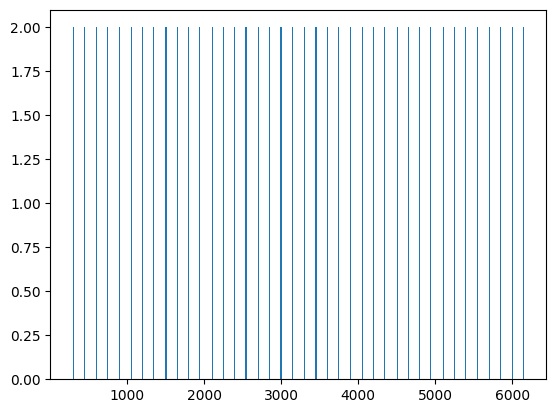

In [14]:
plt.hist(allspikes, bins=400);

In [15]:

if cfg.connect_ThVecStim_S1:

    # for post in Epops: 
    #     convergence_Th_S1['VPM_sTC']['L4_PC'] = 197
    #     convergence_Th_S1['VPM_sTC']['L4_SP'] = 197
    #     convergence_Th_S1['VPM_sTC']['L4_SS'] = 188
    #     convergence_Th_S1['VPM_sTC']['L4_INH'] = 116

    ## Connectivity rules
    synapsesperconnection_Th_S1 = 9.0
    for pre in ['VPM_sTC']:  #  
        if cfg.TC_S1[pre]:
            for post in Epops: 
                
                if 'L4_SS' in post:
                    conn_convergence = np.ceil(188/synapsesperconnection_Th_S1)
                else:
                    conn_convergence = np.ceil(197/synapsesperconnection_Th_S1)

                netParams.connParams['thal_'+pre+'_'+post] = { 
                    'preConds': {'pop': pre},  ####################################################
                    'postConds': {'pop': post},
                    'weight': cfg.TC_S1_weightE,   # synaptic weight 
                    'sec': 'basal', # target postsyn section
                    'delay': 'defaultDelay',
                    'synsPerConn': int(synapsesperconnection_Th_S1),                     
                    'synMech': ESynMech_Th}  

                netParams.connParams['thal_'+pre+'_'+post]['convergence'] = conn_convergence 

            for post in Ipops: 
                
                conn_convergence = np.ceil(116/synapsesperconnection_Th_S1)

                netParams.connParams['thal_'+pre+'_'+post] = { 
                    'preConds': {'pop': pre},  ####################################################
                    'postConds': {'pop': post},
                    'weight': cfg.TC_S1_weightI,   # synaptic weight 
                    'sec': 'somatic', # target postsyn section
                    'delay': 'defaultDelay',
                    'synsPerConn': int(synapsesperconnection_Th_S1),                     
                    'synMech': ESynMech_Th}  

                netParams.connParams['thal_'+pre+'_'+post]['convergence'] = conn_convergence 

print(netParams.connParams.keys())


odict_keys(['thal_VPM_sTC_L4_SSC_cADpyr_3', 'thal_VPM_sTC_L4_SSC_cADpyr_4', 'thal_VPM_sTC_L4_SSC_cADpyr_5', 'thal_VPM_sTC_L4_TPC_cADpyr_6', 'thal_VPM_sTC_L4_TPC_cADpyr_7', 'thal_VPM_sTC_L4_TPC_cADpyr_8', 'thal_VPM_sTC_L4_UPC_cADpyr_9', 'thal_VPM_sTC_L4_UPC_cADpyr_10', 'thal_VPM_sTC_L4_UPC_cADpyr_11', 'thal_VPM_sTC_L4_BP_cNAC_0', 'thal_VPM_sTC_L4_BTC_cNAC_1', 'thal_VPM_sTC_L4_NBC_cNAC_2'])


In [16]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations


Start time:  2025-03-25 16:48:49.892779


{L4_BP_cNAC_0: <netpyne.network.pop.Pop object at 0x7ac0bc85da60>, L4_BTC_cNAC_1: <netpyne.network.pop.Pop object at 0x7ac0bebe2ca0>, L4_NBC_cNAC_2: <netpyne.network.pop.Pop object at 0x7ac0bc84e4c0>, L4_SSC_cADpyr_3: <netpyne.network.pop.Pop object at 0x7ac0bc84e3a0>, L4_SSC_cADpyr_4: <netpyne.network.pop.Pop object at 0x7ac0bc8937f0>, L4_SSC_cADpyr_5: <netpyne.network.pop.Pop object at 0x7ac0bc829820>, L4_TPC_cADpyr_6: <netpyne.network.pop.Pop object at 0x7ac0bc829730>, L4_TPC_cADpyr_7: <netpyne.network.pop.Pop object at 0x7ac0bc829940>, L4_TPC_cADpyr_8: <netpyne.network.pop.Pop object at 0x7ac0bc829610>, L4_UPC_cADpyr_9: <netpyne.network.pop.Pop object at 0x7ac0bc829850>, L4_UPC_cADpyr_10: <netpyne.network.pop.Pop object at 0x7ac0bc829880>, L4_UPC_cADpyr_11: <netpyne.network.pop.Pop object at 0x7ac0bc829ac0>, VPM_sTC: <netpyne.network.pop.Pop object at 0x7ac0bc829bb0>}

In [17]:
sim.net.createCells()              			# instantiate network cells based on defined populations


Creating network of 13 cell populations on 1 hosts...
  Number of cells on node 0: 14 
  Done; cell creation time = 0.37 s.


[compartCell_L4_BP_cNAC_0_HH_full_0,
 compartCell_L4_BTC_cNAC_1_HH_full_1,
 compartCell_L4_NBC_cNAC_2_HH_full_2,
 compartCell_L4_SSC_cADpyr_3_HH_full_3,
 compartCell_L4_SSC_cADpyr_4_HH_full_4,
 compartCell_L4_SSC_cADpyr_5_HH_full_5,
 compartCell_L4_TPC_cADpyr_6_HH_full_6,
 compartCell_L4_TPC_cADpyr_7_HH_full_7,
 compartCell_L4_TPC_cADpyr_8_HH_full_8,
 compartCell_L4_UPC_cADpyr_9_HH_full_9,
 compartCell_L4_UPC_cADpyr_10_HH_full_10,
 compartCell_L4_UPC_cADpyr_11_HH_full_11,
 pointCell_VecStim_12,
 pointCell_VecStim_13]

In [18]:
sim.net.connectCells()            			# create connections between cells based on params

Making connections...
  Number of connections on node 0: 12 
  Number of synaptic contacts on node 0: 216 
  Done; cell connection time = 0.05 s.


[[{preGid: 12, sec: 'soma_0', loc: 0.05555555555555555, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[162]},
  {preGid: 12, sec: 'soma_0', loc: 0.16666666666666666, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[163]},
  {preGid: 12, sec: 'soma_0', loc: 0.2777777777777778, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[164]},
  {preGid: 12, sec: 'soma_0', loc: 0.38888888888888884, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[165]},
  {preGid: 12, sec: 'soma_0', loc: 0.5, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[166]},
  {preGid: 12, sec: 'soma_0', loc: 0.6111111111111112, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[167]},
  {preGid: 12, sec: 'soma_0', loc: 0.7222222222222222, synMech: 'AMPA_Th', weight: 0.0001, delay: 0.1, preLoc: 0.5, hObj: NetCon[168]},
  {preGid: 12, sec: 'soma_0', loc: 0.8333333333333333, synMe

In [19]:
sim.net.addStims() 							# add network stimulation

Adding stims...
  Number of stims on node 0: 12 
  Done; cell stims creation time = 0.00 s.


[[{label: 'Input->108767', source: 'Input_108767', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClamp[0]}],
 [{label: 'Input->141766', source: 'Input_141766', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClamp[1]}],
 [{label: 'Input->138433', source: 'Input_138433', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClamp[2]}],
 [{label: 'Input->139867', source: 'Input_139867', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClamp[3]}],
 [{label: 'Input->141213', source: 'Input_141213', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClamp[4]}],
 [{label: 'Input->141369', source: 'Input_141369', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClamp[5]}],
 [{label: 'Input->133426', source: 'Input_133426', sec: 'soma_0', loc: 0.5, type: 'IClamp', del: 400.0, dur: 12.0, amp: 0.5, hObj: IClam

In [20]:
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)

Recording 12 traces of 1 types on node 0


{spkt: Vector[72848], spkid: Vector[72849], V_soma: {cell_0: Vector[72862], cell_1: Vector[72863], cell_2: Vector[72864], cell_3: Vector[72865], cell_4: Vector[72866], cell_5: Vector[72867], cell_6: Vector[72868], cell_7: Vector[72869], cell_8: Vector[72870], cell_9: Vector[72871], cell_10: Vector[72872], cell_11: Vector[72873]}, _repr_mimebundle_: {}}

In [21]:
sim.runSim()                      			# run parallel Neuron simulation  

0.0s

Running simulation using NEURON for 400.0 ms...
0.1s
0.2s
0.3s
0.4s
  Done; run time = 20.98 s; real-time ratio: 0.02.


In [22]:
sim.gatherData();                  			# gather spiking data and cell info from each node


Gathering data...
  Done; gather time = 0.19 s.

Analyzing...
  Cells: 14
  Connections: 12 (0.86 per cell)
  Synaptic contacts: 216 (15.43 per cell)
  Spikes: 2 (0.36 Hz)
  Simulated time: 0.4 s; 1 workers
  Run time: 20.98 s
   L4_BP_cNAC_0 : 0.000 Hz
   L4_BTC_cNAC_1 : 0.000 Hz
   L4_NBC_cNAC_2 : 0.000 Hz
   L4_SSC_cADpyr_3 : 0.000 Hz
   L4_SSC_cADpyr_4 : 0.000 Hz
   L4_SSC_cADpyr_5 : 0.000 Hz
   L4_TPC_cADpyr_6 : 0.000 Hz
   L4_TPC_cADpyr_7 : 0.000 Hz
   L4_TPC_cADpyr_8 : 0.000 Hz
   L4_UPC_cADpyr_9 : 0.000 Hz
   L4_UPC_cADpyr_10 : 0.000 Hz
   L4_UPC_cADpyr_11 : 0.000 Hz
   VPM_sTC : 2.500 Hz


In [23]:
# Calcular o firing rate
spk_times = sim.simData['spkt']  # Tempos de spikes
spk_ids = sim.simData['spkid']  # IDs dos neurônios

steps, rates = np.unique(spk_ids, return_counts=True)
steps, rates/0.6

(array([12., 13.]), array([1.66666667, 1.66666667]))

In [24]:
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
# sim.analysis.plotData()         			# plot spike raster etc

[]

In [25]:
# sim.analysis.plotSpikeStats(timeRange=[300,900], figSize=(18,6))

Preparing spike data...


Plotting raster...


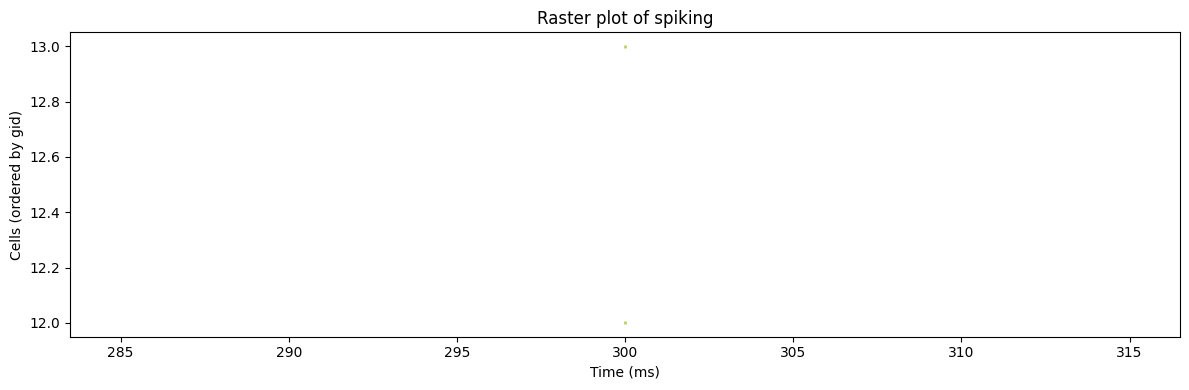

In [26]:
sim.analysis.plotRaster(timeRange=[300,315], figSize=(12,4), popRates=False, labels=None);

Plotting recorded cell traces ... trace


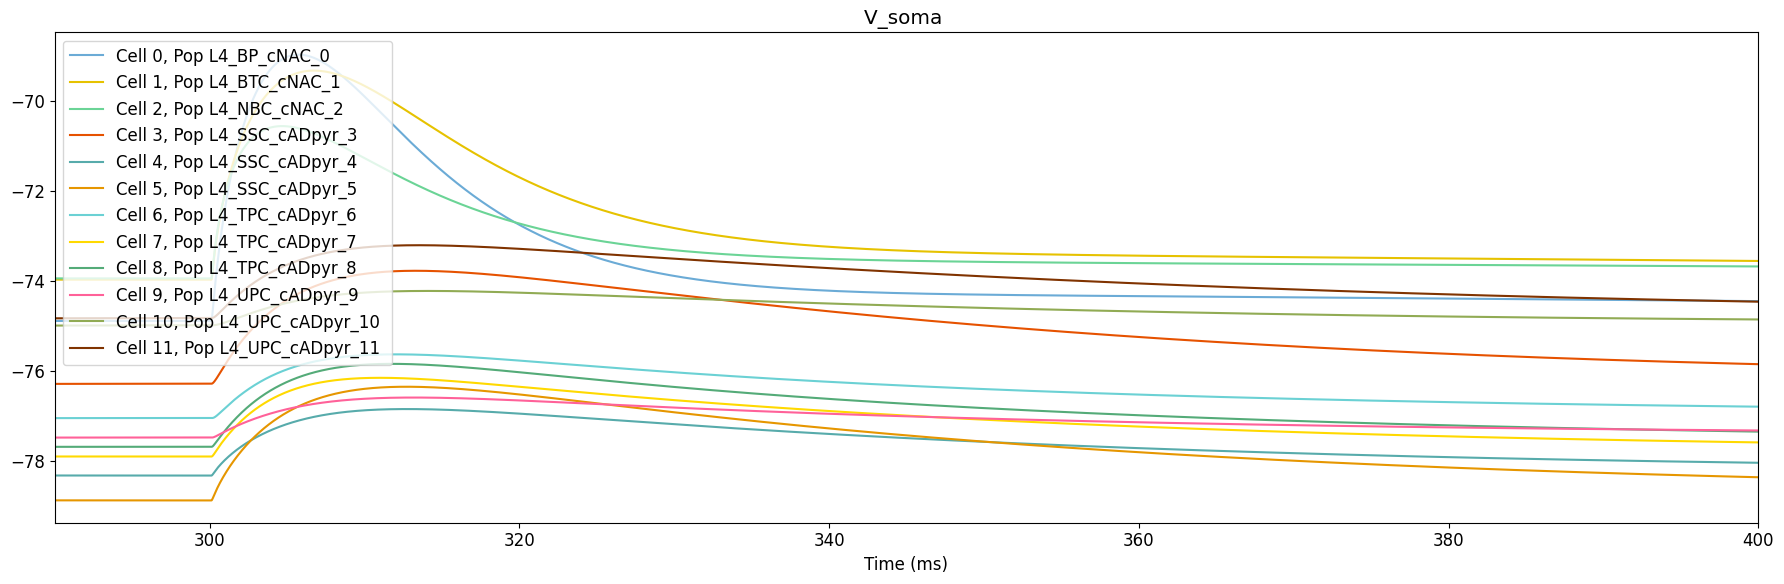

In [27]:
sim.analysis.plotTraces(timeRange=[290,400], overlay=True, oneFigPer='trace', figSize=(18,6));

Plotting recorded cell traces ... trace


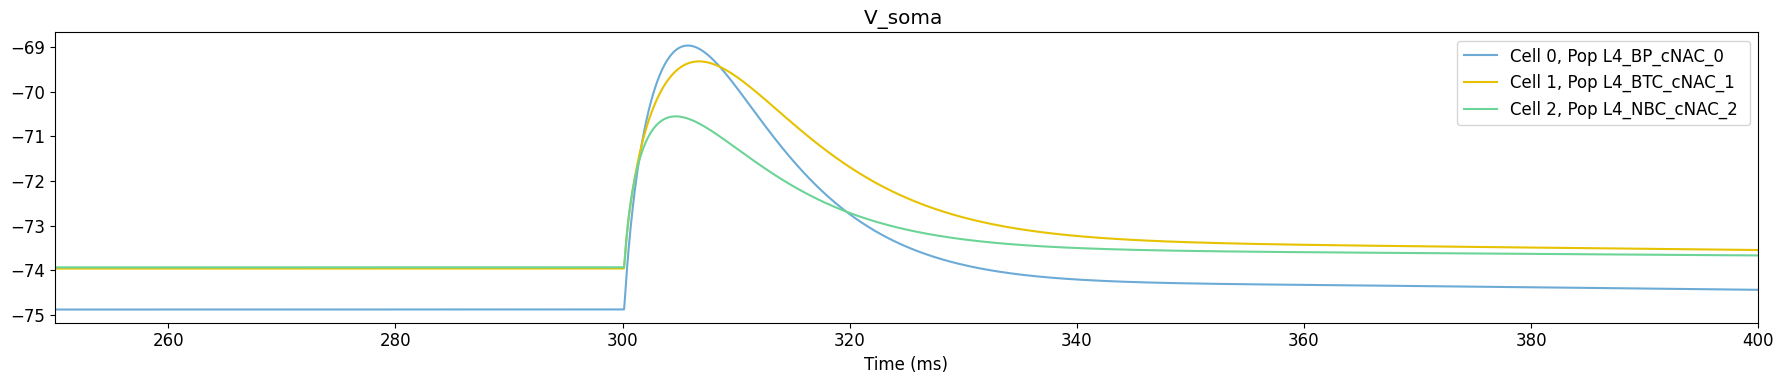

Plotting recorded cell traces ... trace


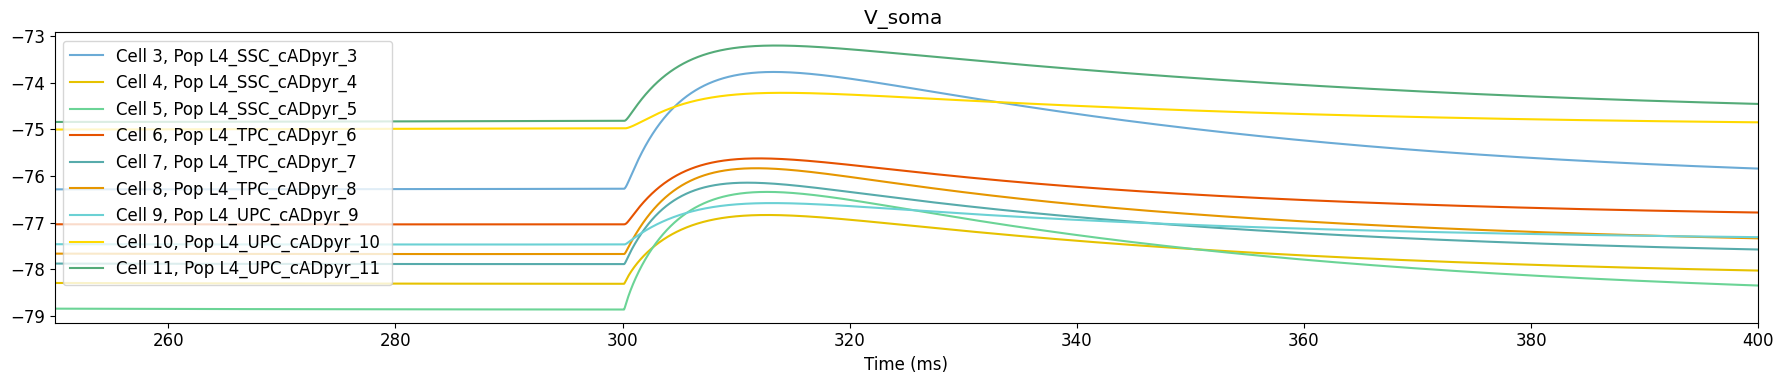

In [37]:
sim.analysis.plotTraces(include= [ii for ii in range(0,3)], timeRange=[250,400], overlay=True, oneFigPer='trace', figSize=(18,4));
sim.analysis.plotTraces(include= [ii for ii in range(3,12)], timeRange=[250,400], overlay=True, oneFigPer='trace', figSize=(18,4));

# sim.analysis.plotTraces(timeRange=[290,320], overlay=False, oneFigPer='trace', figSize=(18,36));

Plotting recorded cell traces ... trace


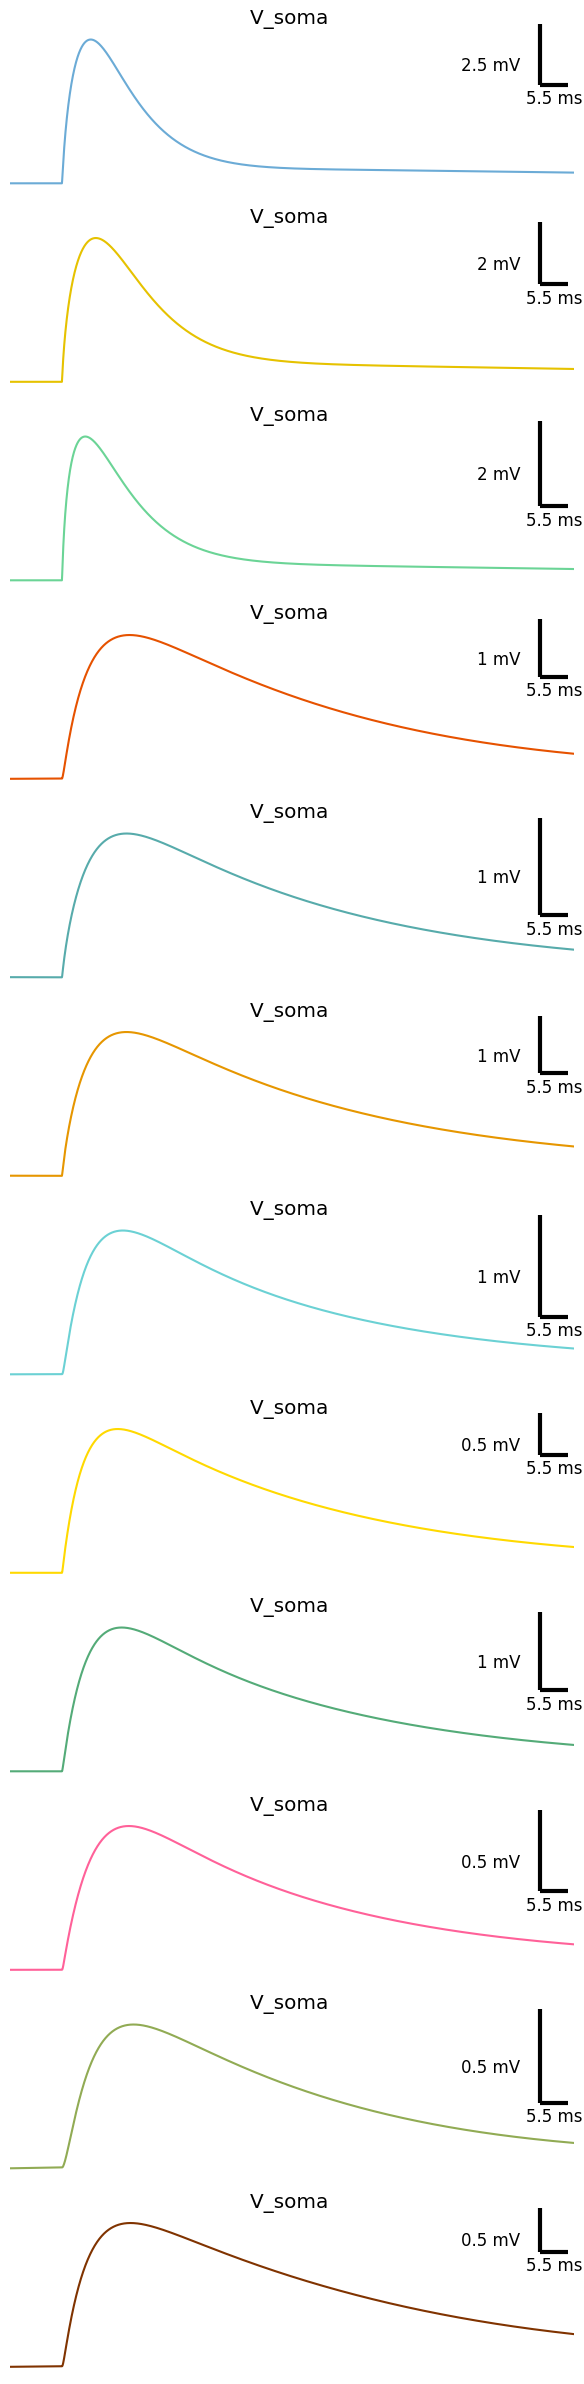

In [40]:
# sim.analysis.plotTraces(include= [ii for ii in range(9)], ylim=[-80,-68], timeRange=[300,320], overlay=False, oneFigPer='trace', figSize=(6,36));
sim.analysis.plotTraces(timeRange=[290,400], overlay=False, axis=False, oneFigPer='trace', figSize=(6,24));

Plotting 3D cell shape ...
Plotting 3D cell shape ...
Plotting 3D cell shape ...


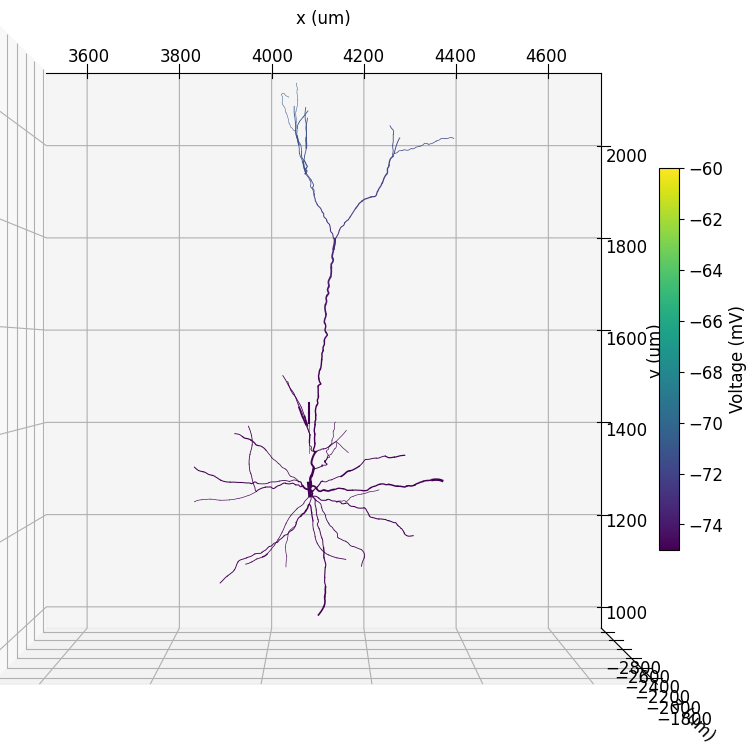

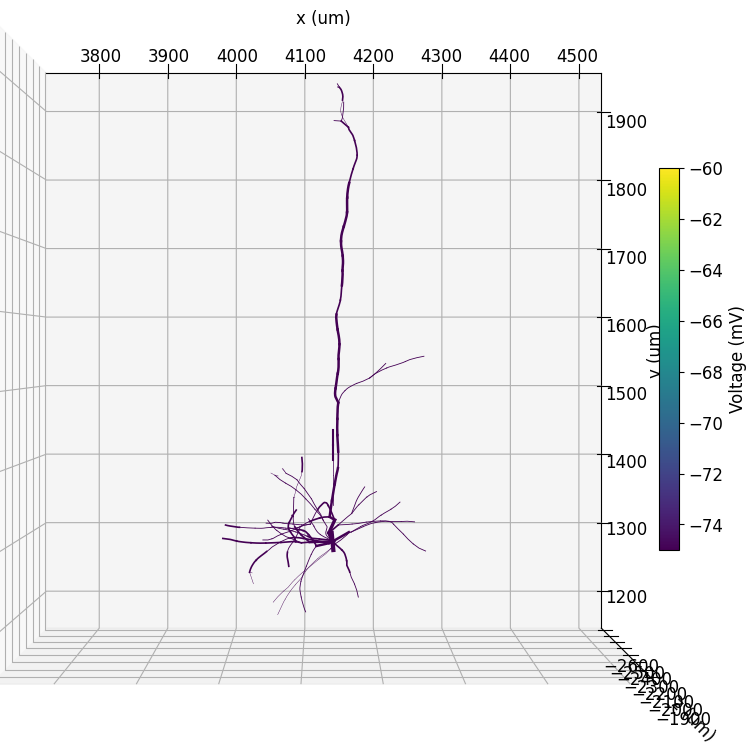

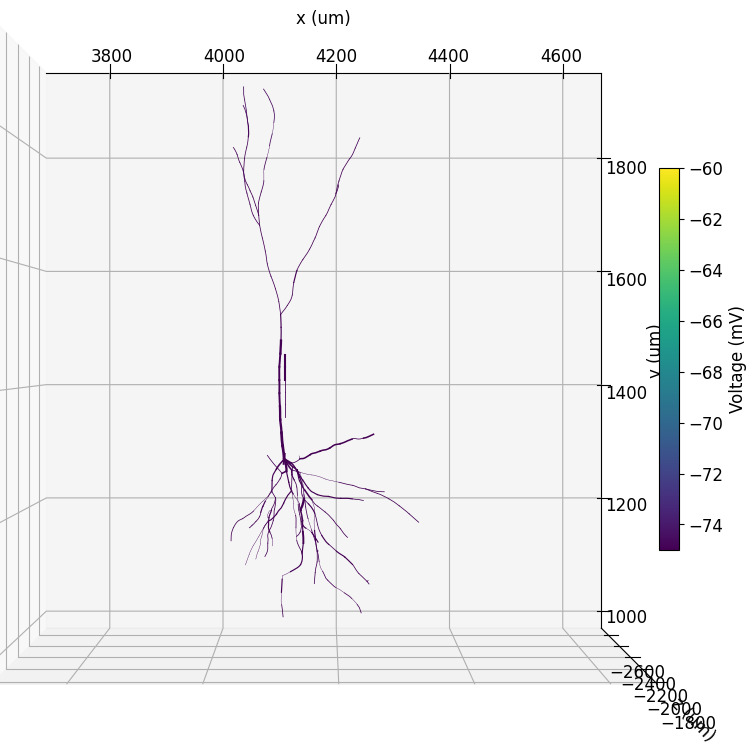

In [30]:
for ii in range(6,9):    
    sim.analysis.plotShape(includePre= [ii], includePost= [ii], 
        includeAxon=False, showSyns=False, showElectrodes=False,
        cvar= 'voltage', dist=0.6, elev=90, azim=-90, 
        axisLabels=True, synStyle='o', 
        clim= [-75, -60], showFig=False, synSize=2, saveFig=False, figSize=(8,8))

Plotting 3D cell shape ...


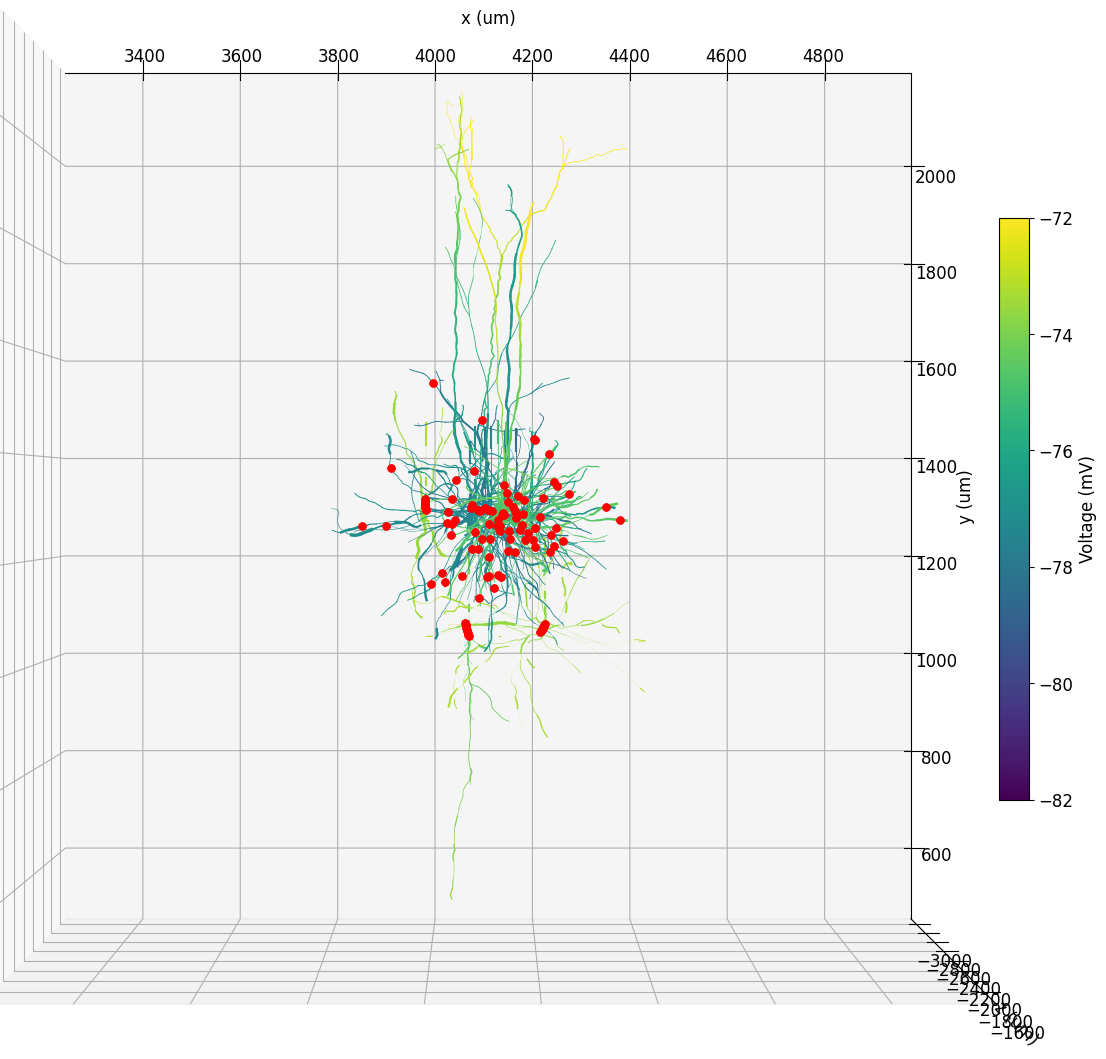

In [41]:
sim.analysis.plotShape(includePre= [ii for ii in range(12)], includePost= [ii for ii in range(12)], 
        includeAxon=True, showSyns=True, showElectrodes=False,
        cvar= 'voltage', dist=0.6, elev=90, azim=-90, 
        axisLabels=True, synStyle='o', 
        clim= [-82, -72], showFig=False, synSize=5, saveFig=False, figSize=(12,12));

Plotting 3D cell shape ...


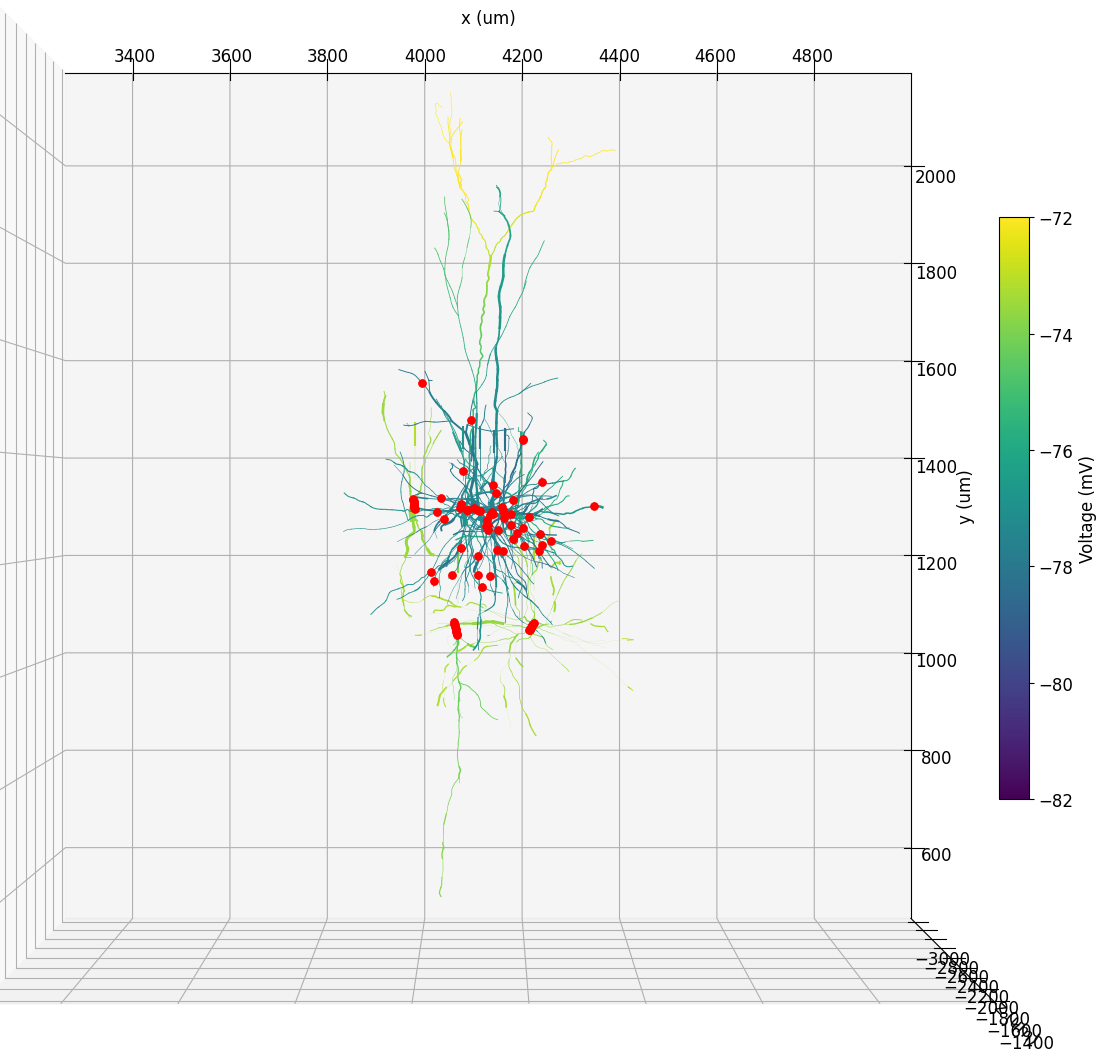

In [32]:
sim.analysis.plotShape(includePre= [ii for ii in range(9)], includePost= [ii for ii in range(9)], 
        includeAxon=False, showSyns=True, showElectrodes=False,
        cvar= 'voltage', dist=0.6, elev=90, azim=-90, 
        axisLabels=True, synStyle='o', 
        clim= [-82, -72], showFig=False, synSize=5, saveFig=False, figSize=(12,12));